# Aim

Two layers for my project: First, can see which words correspond to the most claps. Then (or instead of that), I can cluster my titles by topic, and if my topics are interpretable, I can show which topics lead to the most claps.

1) Cluster article titles in the "Towards Data Science" publication, to find clusters that make the most sense

2) Find which clusters (word themes) lead to the largest numbers of claps. Possibly use (claps / number of followers) in order to normalize for the number of followers that one already has. Though, followers can be a lot of dead weight that then penalize posters that are too popular a priori (think Youtube subscribers - not all active)

3) (Optional) **Make a "Data Science article title generator" (speak to Aaron)**

4) (Optional 2) Make a ranker that will rank your data science title based on its word properties

In [748]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
import seaborn as sns

pyLDAvis.enable_notebook()
%matplotlib inline

from collections import namedtuple


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows = 20

# Read pickle

In [3]:
titles = pd.read_pickle('titles.pkl')

In [4]:
df_kaggle = pd.read_pickle('df.pkl')

# EDA

What words are most common?

# Count Vectorizer

In [5]:
cv1 = CountVectorizer(stop_words = 'english', ngram_range = (1,1))
# Can change ngram_range to get different word lengths too

In [6]:
titles

1485      Published previously for Venturebeat and the Z...
2829      Inferring the effect of Brand Search using Cau...
3134                      4 WAYS TO SUM DATA BY WEEK NUMBER
5268      AR, AI, Ay Yi Yi: 2 Takeaways from NYC Media L...
5448                  Engineer’s Guide to Julia Programming
6882      Speeding up your code (4): in-time compilation...
7335      A.I. Powered Customer Data & Insights Company ...
8043      Technology Fridays: Comet.ML Wants to be the G...
10070     Three instructive and complementary Capsule Ne...
12009                   Convolutional Networks for everyone
                                ...                        
279433                      The End of Open AI Competitions
279448                  Creating your AI projects on Kaggle
279458                                 Self Organizing Maps
279472                       Deep Learning on Car Simulator
279476      Data Science, Neuroscience, and Medical Devices
279514      MLiterature: Regression Eval

In [7]:
title_vec = cv1.fit_transform(titles)

In [8]:
df = pd.DataFrame(title_vec.toarray(), index = titles, columns=cv1.get_feature_names()) # Make a df of results

df.sum(axis=0).sort_values(ascending = False)[:20] # Sum feature columns, get top words

data             879
learning         813
machine          412
deep             354
science          339
using            297
ai               255
python           247
neural           205
networks         164
analysis         130
tensorflow       112
artificial       106
intelligence     105
network           93
model             92
regression        89
introduction      88
code              85
understanding     83
dtype: int64

Result: Overall the words "data" and "learning" far outpace the use of other words in my Towards Data Science sample

# KMeans

# PCA (Count Vectorizer)

In [9]:
pca = PCA(n_components = 10, random_state = 37)

np_pca = pca.fit_transform(df)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=37,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
pca.singular_values_

array([33.93706131, 28.8123223 , 20.50989035, 17.92705594, 17.16760919,
       15.83428566, 15.02379721, 14.70359797, 14.02475964, 12.10030319])

In [12]:
pca.explained_variance_ratio_

array([0.05405372, 0.03896132, 0.01974257, 0.01508325, 0.01383237,
       0.01176722, 0.01059343, 0.01014669, 0.00923141, 0.00687179])

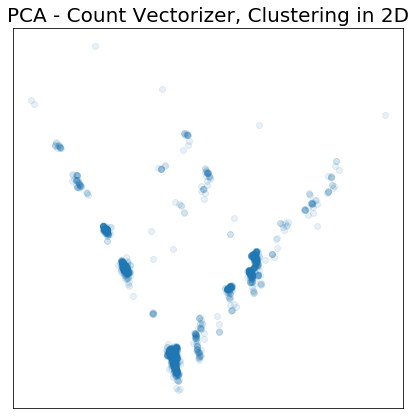

In [754]:
plt.figure(figsize = (7,7))
plt.scatter(np_pca[:,0], np_pca[:,1], alpha = 0.1)
plt.title('PCA - Count Vectorizer, Clustering in 2D', size = 20)
plt.xticks(ticks = [])
plt.yticks(ticks = [])
plt.savefig('pca_countvec.png', bbox_inches = 'tight')

# PCA (TF-IDF)

In [14]:
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,1))

title_tfidf = tfidf.fit_transform(titles)

In [15]:
df_tfidf = pd.DataFrame(title_tfidf.toarray(), index = titles, columns = tfidf.get_feature_names())

df_tfidf.head()

,000,01,02,09,10,100,1000,100gb,100k,101,...,zag,zca,zeppelin,zero,zetta,zig,zillow,zip,zipf,zylotech
title,,,,,,,,,,,,,,,,,,,,,
Published previously for Venturebeat and the Zetta Ventures blog:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.422208,0.0,0.0,0.0,0.0,0.0
Inferring the effect of Brand Search using CausalImpact,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4 WAYS TO SUM DATA BY WEEK NUMBER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
"AR, AI, Ay Yi Yi: 2 Takeaways from NYC Media Lab 2017",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Engineer’s Guide to Julia Programming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
pca_n2 = PCA(n_components = 2, random_state = 37)

np_pca_tfidf = pca_n2.fit_transform(df_tfidf)

In [17]:
np_pca_tfidf.shape

(3835, 2)

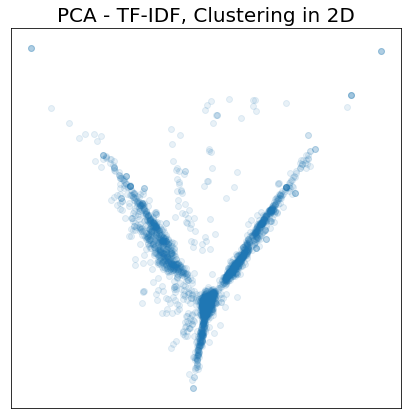

In [735]:
plt.figure(figsize = (7,7))
plt.scatter(np_pca_tfidf[:,0], np_pca_tfidf[:,1], alpha = 0.1)
plt.title('PCA - TF-IDF, Clustering in 2D', size = 20)
plt.xticks(ticks = [])
plt.yticks(ticks = []);
plt.savefig('pca_tfidf.png', bbox_inches = 'tight')

# NMF (Count Vectorizer)

In [19]:
nmf = NMF(n_components = 2, random_state = 37)

np_nmf = nmf.fit_transform(df)

In [20]:
np_nmf.shape

(3835, 2)

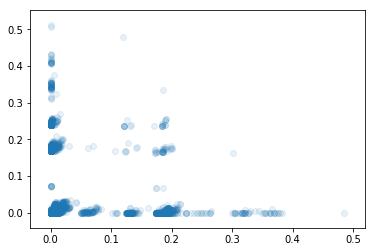

In [21]:
plt.scatter(np_nmf[:,0], np_nmf[:,1], alpha = 0.1)

In [22]:
nmf_10 = NMF(n_components = 10, random_state = 37)

np_nmf_10 = nmf_10.fit_transform(df)

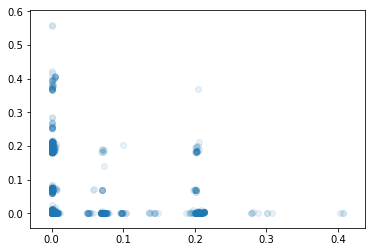

In [23]:
plt.scatter(np_nmf_10[:,0], np_nmf_10[:,1], alpha = 0.1)

**Incorporate elbow method graphing into determining ideal number of clusters - if I am using clustering**

**Solution file for K-Means pair problem - plots inertia with LDA (cannot use with NMF)**

# Topic Modeling

In [24]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [25]:
pca_n5 = PCA(n_components = 5, random_state = 37)

pca_n5.fit(df_tfidf)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=37,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
# Count Vectorized Version
display_topics(pca_n5, tfidf.get_feature_names(), 10)


Topic  1
data, science, scientist, python, scientists, analysis, intro, startups, driven, big

Topic  2
learning, data, science, machine, deep, scientist, python, journey, startups, bmw

Topic  3
neural, networks, deep, convolutional, science, network, data, learning, understanding, recurrent

Topic  4
artificial, intelligence, machine, neural, networks, convolutional, science, network, human, general

Topic  5
deep, intelligence, artificial, ai, new, research, learning, science, reinforcement, studio


## LDA + pyLDAvis

In [143]:
pca_10 = PCA(n_components = 10, random_state = 37)
pca_10.fit(df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=37,
  svd_solver='auto', tol=0.0, whiten=False)

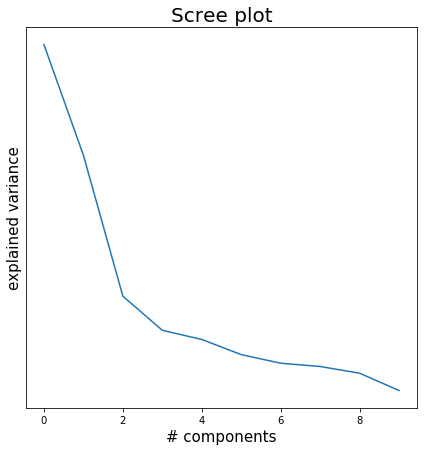

In [758]:
plt.figure(figsize = (7,7))
plt.plot(pca_10.explained_variance_ratio_)
plt.xlabel('# components', size = 15)
plt.ylabel('explained variance', size = 15)
plt.yticks(ticks = [])
plt.title('Scree plot', size = 20)
plt.savefig('scree_plot.png', bbox_inches = 'tight');

In [145]:
lda = LatentDirichletAllocation(n_components = 4, random_state = 37)

lda.fit(df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=37, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [146]:
pyLDAvis.sklearn.prepare(lda, title_vec, cv1)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.075117  0.192769       1        1  32.289378
1     -0.198250  0.007692       2        1  26.793106
2      0.125284 -0.105046       3        1  22.128084
0     -0.002151 -0.095415       4        1  18.789432, topic_info=     Category        Freq           Term       Total  loglift  logprob
1048  Default  714.000000           data  714.000000  30.0000  30.0000
2442  Default  676.000000       learning  676.000000  29.0000  29.0000
3727  Default  276.000000        science  276.000000  28.0000  28.0000
1110  Default  295.000000           deep  295.000000  27.0000  27.0000
2560  Default  342.000000        machine  342.000000  26.0000  26.0000
3416  Default  202.000000         python  202.000000  25.0000  25.0000
4214  Default   91.000000     tensorflow   91.000000  24.0000  24.0000
206   Default  106.000000       analysis  106.000000  23.0000  23.0000
160   Default  211.000000             ai  211.000000  22.0000  22.0000
3529  Default   73.000000     regression   73.000000  21.0000  21.0000
...       ...         ...            ...         ...      ...      ...
249    Topic4   13.547341            api   21.132394   1.2273  -5.6861
1048   Topic4   88.155398           data  714.328489  -0.4204  -3.8132
751    Topic4   22.930914           code   70.220250   0.5527  -5.1598
1064   Topic4   11.856048       datasets   23.634283   0.9820  -5.8195
550    Topic4   14.142462          build   39.166879   0.6532  -5.6431
30     Topic4   13.280849           2017   33.640860   0.7425  -5.7060
1871   Topic4   16.035517         google   60.894208   0.3375  -5.5175
2768   Topic4   15.254659          model   76.487144   0.0596  -5.5674
4      Topic4   11.988461             10   28.403856   0.8093  -5.8084
4415   Topic4   13.179436  understanding   68.955646   0.0171  -5.7137

[240 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         2  0.563304        10
4         4  0.422478        10
30        1  0.445886      2017
30        2  0.089177      2017
30        3  0.089177      2017
30        4  0.386435      2017
31        1  0.305666      2018
31        2  0.550199      2018
31        4  0.122266      2018
51        3  0.952574        3d
...     ...       ...       ...
4583      3  0.611389       web
4583      4  0.191059       web
4589      3  0.712523      week
4589      4  0.277092      week
4591      2  0.167186    weekly
4591      3  0.780200    weekly
4633      2  0.036034      word
4633      3  0.936883      word
4640      2  0.946935  workflow
4659      2  0.861548     wrong

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

**Topic 1 (32%) - Core DS Techniques**: Machine Learning, Deep learning, AI, Neural Networks Top 8 terms

**Topic 2 (27%) - Generic/People**: Data and Science account for most of this cluster. Scientist, Know, and Visualization come in as well

**Topic 3 (22%) - Practical Skills**: Python, Analysis, Using, Linear, Regression

**Topic 4 (19%) - Big Data/Tools**: Tensorflow, Classification, Image, Detection, Recognition, Gradient Descent, Pytorch

# Clap Analysis Prep
**(On the topics vs claps, to see which topics lead to the most claps)**

In [160]:
np_lda = lda.transform(df)

np_lda.shape

(3835, 4)

In [197]:
# Making a df with my LDA results

df_lda = pd.DataFrame(np_lda, index = titles, columns = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'])

In [ ]:
# Get the title_index so I can join my data
df_lda['title_index'] = list(titles.reset_index()['index'])

# Readjusts the index so that I can then join on the index for claps
df_lda.reset_index(inplace = True)
df_lda.set_index(keys = 'title_index', inplace = True)

# Joins claps to the index
df_lda = df_lda.join(df_kaggle[['totalClapCount']])

In [203]:
df_lda.head()

,title,Topic 1,Topic 2,Topic 3,Topic 4,totalClapCount
title_index,,,,,,
1485,Published previously for Venturebeat and the Z...,0.035902,0.036391,0.891967,0.035740,15
2829,Inferring the effect of Brand Search using Cau...,0.038147,0.885432,0.040070,0.036351,15
3134,4 WAYS TO SUM DATA BY WEEK NUMBER,0.586293,0.326000,0.045267,0.042439,1
5268,"AR, AI, Ay Yi Yi: 2 Takeaways from NYC Media L...",0.024235,0.928609,0.023004,0.024152,0
5448,Engineer’s Guide to Julia Programming,0.844201,0.052717,0.051116,0.051966,1


## Exploration

In [474]:
df_sorted = df_lda.sort_values(by = 'totalClapCount', ascending = False)

In [475]:
df_sorted.head()

,title,Topic 1,Topic 2,Topic 3,Topic 4,totalClapCount
title_index,,,,,,
259111,Why so many data scientists are leaving their ...,0.050517,0.848493,0.050799,0.050191,30696
272172,A Tour of The Top 10 Algorithms for Machine Le...,0.036697,0.681647,0.036179,0.245477,23270
246835,How to build your own Neural Network from scra...,0.043007,0.243147,0.671124,0.042721,22511
241897,Introduction to Markov Chains,0.062562,0.062508,0.811949,0.062981,18242
250124,Who Is Going To Make Money In AI? Part I,0.304267,0.588403,0.052338,0.054992,15097


In [620]:
df_lda['totalClapCount'].sum()

2097810

In [622]:
df_lda.loc[df_lda['totalClapCount'] > 5000, 'totalClapCount'].sum()

538067

In [624]:
df_lda.loc[df_lda['totalClapCount'] > 5000, 'totalClapCount'].count() / df_lda['totalClapCount'].count()

0.01564537157757497

My population of article claps has a GINI coefficient of 0.73 - which is higher than any country on Earth. The US's GINI coefficient is between 0.40-0.45, while South Africa's (the highest) is 0.63

In [ ]:
# X-axis is all articles, sorted in order of most to least claps
# Y-axis is clap count

df_sorted_asc = df_lda.sort_values(by= 'totalClapCount')

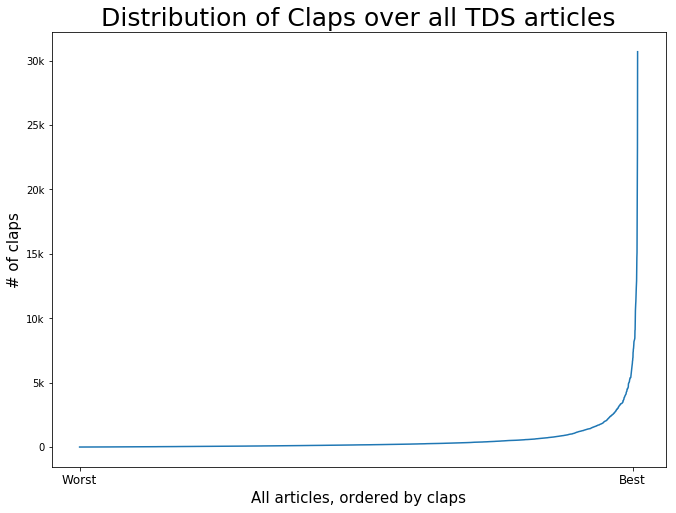

In [742]:
plt.figure(figsize = (11,8))
sns.lineplot(range(df_sorted.shape[0]), list(df_sorted_asc['totalClapCount']))
plt.title('Distribution of Claps over all TDS articles', size = 25)
plt.xticks(ticks=[0, 3800], labels = ['Worst', 'Best'], size = 12)
plt.yticks(ticks = [0, 5000, 10000, 15000, 20000, 25000, 30000], labels = ['0', '5k', '10k', '15k', '20k', '25k', '30k'])
plt.xlabel('All articles, ordered by claps', size = 15)
plt.ylabel('# of claps', size = 15);
plt.savefig('clap_dist.png', bbox_inches = 'tight')

In [690]:
df_lda.loc[df_lda['totalClapCount'] > 5000, 'totalClapCount'].count() / df_lda.loc[:, 'totalClapCount'].count()

0.01564537157757497

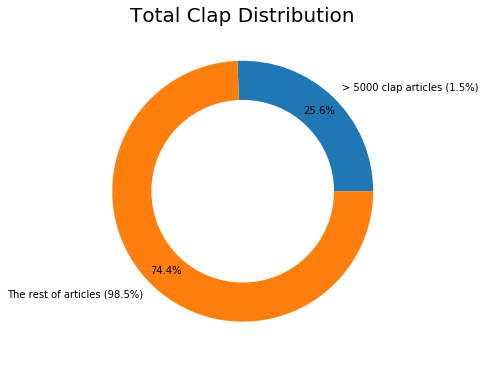

In [720]:
# Make a pie chart showing the inequality in claps

pie_sizes = [df_lda.loc[df_lda['totalClapCount'] > 5000, 'totalClapCount'].sum(), # Summing claps from articles >5000 total claps
             df_lda.loc[df_lda['totalClapCount'] <= 5000, 'totalClapCount'].sum()] # Taking the remainder of the claps

pie_labels = ('> 5000 clap articles (1.5%)', 'The rest of articles (98.5%)')

plt.figure(figsize = (6,6))
plt.pie(pie_sizes, labels = pie_labels, autopct='%1.1f%%',pctdistance=0.85)

# Draw a white circle inside to improve the pie chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Total Clap Distribution", size = 20);

In [477]:
# Setting the minimum number of claps == 1, so that I don't have "divide by zero" errors
df_sorted.loc[df_['totalClapCount'] == 0, 'totalClapCount'] = 1

In [478]:
X = df_sorted.loc[:, 'Topic 1':'Topic 4']
y = df_sorted['totalClapCount']

In [497]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 37)

In [498]:
# Finding what topics are the strongest for each title
X.idxmax(axis=1).value_counts()

Topic 4    1272
Topic 2    1086
Topic 3     840
Topic 1     637
dtype: int64

In [499]:
# Average topic % that my model predicts
X.mean()

Topic 1    0.184882
Topic 2    0.274448
Topic 3    0.224264
Topic 4    0.316406
dtype: float64

**Conclusion** - My strongest topics are assigned above. Which topics appear the most often is independent of the % of tokens, which simply counts how many tokens (NLP terms) are assigned to the clusters

Han Wei suggests fitting the strongest model I possibly can, then feed it fake data that I generate at the intervals I want (0,0,0,100), (0,0,5,95), etc etc... My strongest model can then predict claps that would result from each topic, which I can then graph (in fact, this might be a more "pure" version of my experiment, since it would eliminate correlations between topics that would create issues in my interpretation of what *causes* higher clap counts

# Training a Neural Net - here we go!

In [491]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [594]:
main_input = Input(shape = (4,), name = 'main_input')
out = Dense(64, activation = 'sigmoid')(main_input)
out = Dense(128, activation = 'sigmoid')(out)
# out = Dense(256, activation = 'sigmoid')(out)
# out = Dense(256*2, activation = 'sigmoid')(out)
loss = Dense(1, activation = 'linear')(out)

model = Model(inputs = [main_input], outputs = [loss])
model.compile(loss='mean_squared_error', optimizer = 'sgd')

In [595]:
# Running the neural net
model.fit(X_train, y_train, epochs = 1000,\
          batch_size = 64)

Epoch 1/1000
2876/2876 [==============================] - 1s 373us/step - loss: 2358698.6686
Epoch 2/1000
2876/2876 [==============================] - 0s 46us/step - loss: 2356358.0311
Epoch 3/1000
2876/2876 [==============================] - 0s 45us/step - loss: 2331590.6147
Epoch 4/1000
2876/2876 [==============================] - 0s 43us/step - loss: 2315652.0750
Epoch 5/1000
2876/2876 [==============================] - 0s 44us/step - loss: 2313326.0505
Epoch 6/1000
2876/2876 [==============================] - 0s 38us/step - loss: 2358333.1875
Epoch 7/1000
2876/2876 [==============================] - 0s 42us/step - loss: 2398870.0170
Epoch 8/1000
2876/2876 [==============================] - 0s 46us/step - loss: 2372494.0504
Epoch 9/1000
2876/2876 [==============================] - 0s 41us/step - loss: 2290648.0323
Epoch 10/1000
2876/2876 [==============================] - 0s 33us/step - loss: 2328498.9364
Epoch 11/1000
2876/2876 [==============================] - 0s 36us/step - loss

2876/2876 [==============================] - 0s 18us/step - loss: 2293718.7778
Epoch 89/1000
2876/2876 [==============================] - 0s 19us/step - loss: 2262054.7504
Epoch 90/1000
2876/2876 [==============================] - 0s 18us/step - loss: 2279216.6492
Epoch 91/1000
2876/2876 [==============================] - 0s 20us/step - loss: 2309749.1591
Epoch 92/1000
2876/2876 [==============================] - 0s 21us/step - loss: 2285954.0358
Epoch 93/1000
2876/2876 [==============================] - 0s 24us/step - loss: 2285301.2010
Epoch 94/1000
2876/2876 [==============================] - 0s 44us/step - loss: 2223588.5692
Epoch 95/1000
2876/2876 [==============================] - 0s 37us/step - loss: 2212130.0810
Epoch 96/1000
2876/2876 [==============================] - 0s 41us/step - loss: 2281635.9562
Epoch 97/1000
2876/2876 [==============================] - 0s 46us/step - loss: 2263123.2639
Epoch 98/1000
2876/2876 [==============================] - 0s 36us/step - loss: 2244

KeyboardInterrupt: 

In [ ]:
X_train.head()

In [591]:
# Prediction is still unusually terrible
model.predict(X_train)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [581]:
model.predict(X_test)

array([[316.96655],
       [316.96658],
       [316.9666 ],
       [316.96655],
       [316.96658],
       [316.9666 ],
       [316.96655],
       [316.96655],
       [316.96658],
       [316.96658],
       [316.96658],
       [316.96655],
       [316.96655],
       [316.96658],
       [316.9666 ],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.9666 ],
       [316.96655],
       [316.96655],
       [316.96658],
       [316.96658],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.9666 ],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96658],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.9666 ],
       [316.96655],
       [316.96658],
       [316.96658],
       [316.9666 ],
       [316.96658],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],
       [316.96655],


In [575]:
model.score()

AttributeError: 'Model' object has no attribute 'score'

Simple MLP Regressor

In [743]:
mlp = MLPRegressor(max_iter = 500, random_state = 37)

In [744]:
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=37, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [745]:
pred = mlp.predict(X_test)

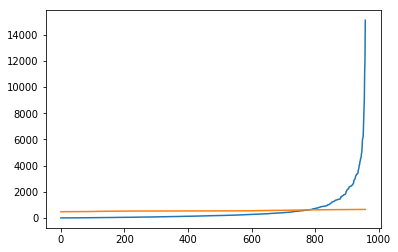

In [746]:
plt.plot(sorted(y_test))
plt.plot(sorted(pred));

In [749]:
r2_score(y_test, pred)

-0.00010015180783540245

In [747]:
print('Min and Max from Neural Net prediction: ', np.min(pred), '/ ', np.max(pred))

print('Min and Max from test set: ', np.min(y_test), '/ ', np.max(y_test))

Min and Max from Neural Net prediction:  472.32936228959545 /  648.1151684474228
Min and Max from test set:  0.0 /  15097.0


In [628]:
df_lda['totalClapCount'].mean()

547.0169491525423

***Result***: My super simple neural net above made better predictions than any nets that add more parameters (even a special neural net that uses keras). This goes to show how fickle neural nets can be

# Random Forest

In [537]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 37, n_jobs = -1)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

In [538]:
rf.score(X_test, y_test)

-0.17052256984009273

# Expanding LDA: Add more topics (n = 30, instead of n = 4)

***Conclusion***: Expanding the topics to try to find some kernel of predictability doesn't work. After all this, we can conclude that finding a predictive model for what topics lead to more claps on your article is not possible (with our current methods of machine learning)

In [559]:
lda_big = LatentDirichletAllocation(n_components = 30, random_state = 37)

lda_big.fit(df)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=30, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=37, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [560]:
np_lda_big = lda_big.transform(df)
df_lda_big = pd.DataFrame(np_lda_big, index = titles)

In [561]:
# Get the title_index so I can join my data
df_lda_big['title_index'] = list(titles.reset_index()['index'])

# Readjusts the index so that I can then join on the index for claps
df_lda_big.reset_index(inplace = True)
df_lda_big.set_index(keys = 'title_index', inplace = True)

# Joins claps to the index
df_lda_big = df_lda_big.join(df_kaggle[['totalClapCount']])

In [562]:
X_big = df_lda_big.iloc[:,1:-1]
y_big = df_lda_big['totalClapCount']

In [563]:
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_big, y_big, random_state = 37)

In [564]:
rf.fit(X_train_big, y_train_big)

rf.score(X_test_big, y_test_big)

-0.14139664265634422

# Linear Regression

I could train my model on all my data, and then have it predict how many claps every topic will get for each increment of 5%, then plot all those together on a 2D graph

In [221]:
lr = LinearRegression(n_jobs = -1)
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [222]:
lr.score(X,y) # Well this model doesn't do too well

0.0013830640630666524

# Simple Topic-to-Clap Calculation

I will calculate the "simple sum" by multiplying each title's assignment to a topic, and taking the sum of the articles, to show which article has the highest sum of claps

In [498]:
# The assigned topic is whichever one has a plurality of 
X.idxmax(axis=1).value_counts()

Topic 4    1272
Topic 2    1086
Topic 3     840
Topic 1     637
dtype: int64

In [499]:
# Mean topic assignment from my model (31.6% of all topic assignment to titles is to Topic 4, etc...)
X.mean()

Topic 1    0.184882
Topic 2    0.274448
Topic 3    0.224264
Topic 4    0.316406
dtype: float64

# Finding the mean

In [615]:
# Here I am iterating through every column of the data, multiplying the topic percentage by the total clap count, and summing that product
# into the total claps that my model attributes to different topics
topics_clap_total = []

for column_num in range(4):
    topics_clap_total.append((df_lda.iloc[:,column_num + 1] * df_lda.iloc[:,-1]).sum())

topics_clap_total # Each topic's total claps, in order (percentage * totalClapCount)

[355584.0818864311, 637602.2638832205, 469740.63051745226, 634883.0237128963]

In [616]:
# In this cell I'm going to take each topic's total clap count, and divide it by the percentage that the topics show up in my dataset
# From that, I will get a scaled number that shows the claps that each of the 4 topics get.

normalized_topic_claps = []

for i in range(4):
    normalized_topic_claps.append(topics_clap_total[i] / list(X.mean())[i]) # Take Topic 1 totalClaps / Topic 1 mean % appearance, Topic 2,3,4
    
normalized_topic_claps

[1923301.6066772873, 2323216.6558403494, 2094590.330620867, 2006544.7636880681]

In [617]:
# Calculates each topic's percentage of claps relative to Topic 1
for idx, i in enumerate(normalized_topic_claps):
    print(f'Topic {idx+1} importance:', i / normalized_topic_claps[0])
    
# Ex: Topic 2's answer is what percentage "better" that topic is in getting claps compared to Topic 1. Topic 1 was arbritrarily decided
# as the denominator for this comparison - though any topic would work

Topic 1 importance: 1.0
Topic 2 importance: 1.207931531786093
Topic 3 importance: 1.0890597311149235
Topic 4 importance: 1.0432813848445708


***Conclusion***:

    Topic 1:   Base measure of percentages

    Topic 2:   21% better than Topic 1 at getting claps

    Topic 3:   9% better than Topic 1 at getting claps

    Topic 4:   4% better than Topic 1 at getting claps

# Pair words/topics to clap counts

Aim: To see what words or topics perform best in clap count

### Pairing single words to clap counts

Given a title like "Exploratory Analysis of Deep Learning", I'd take that article's clap count, and add clap count to each of the words "exploratory", "analysis", etc. Then I'd avg the clap count that each word has, to see which word has the highest clap count on avg.

In [27]:
df.head()

,000,01,02,09,10,100,1000,100gb,100k,101,...,zag,zca,zeppelin,zero,zetta,zig,zillow,zip,zipf,zylotech
title,,,,,,,,,,,,,,,,,,,,,
Published previously for Venturebeat and the Zetta Ventures blog:,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Inferring the effect of Brand Search using CausalImpact,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4 WAYS TO SUM DATA BY WEEK NUMBER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"AR, AI, Ay Yi Yi: 2 Takeaways from NYC Media Lab 2017",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Engineer’s Guide to Julia Programming,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df2 = df.reset_index()

In [29]:
df2['title'].value_counts() # Checking for duplicate titles - need to reincorporate index since titles not unique

Financial data analysis                                                                                4
Intro to Data Science                                                                                  3
How I extracted insights from RAW data : a step by step Data Visualization based on Moroccan Jumia…    2
Who’s Tweeting from the Oval Office?                                                                   2
Bite-sized data science                                                                                2
[ICLR][NVIDIA] Progressive generative adversarial networks (GANs) explained with art forgery …         2
Engineer’s Guide to Julia Programming                                                                  2
Docker for Data Science                                                                                2
25 Lights                                                                                              2
Activation Functions: Neural Networks                  

In [30]:
df['data'].value_counts() # We see that we have multiple words appearing in titles

0    3014
1     765
2      54
3       2
Name: data, dtype: int64

In [31]:
df2['title_index'] = titles.reset_index()['index']

I will choose to not join follower count for the clap analysis - I can't think of a clean way to account for followers appropriately. Folllowers could be dead weight for older, more established accounts (like youtube subscribers - it means almost nothing). If not factoring in followers is giving them too much power in my analysis, then dividing claps by followers would be giving them too little, and giving preference to brand new accounts.

Instead, I will choose to use 'totalClapCount'

In [32]:
df2.set_index('title_index', inplace = True)

df_clap = df2.join(df_kaggle[['totalClapCount','usersFollowedCount']])

In [83]:
# Dropping words that show up less than 5 times in my article
title_words = list(df.columns)
drop_words = []

for word in title_words:
    if df_clap[word].sum() < 50: # If the word appears <5 times in my dataset
        drop_words.append(word) # Add the word to be dropped later
        
drop_words        

['000',
 '01',
 '02',
 '09',
 '10',
 '100',
 '1000',
 '100gb',
 '100k',
 '101',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '18th',
 '19',
 '1900',
 '1996',
 '1d',
 '1st',
 '20',
 '2008',
 '2011',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2022',
 '21',
 '2118',
 '21st',
 '22',
 '23',
 '24',
 '25',
 '269',
 '29',
 '2d',
 '2nd',
 '2x',
 '30',
 '311',
 '34',
 '3a',
 '3b',
 '3d',
 '40',
 '45',
 '499',
 '50',
 '500k',
 '5x',
 '60',
 '68',
 '6x',
 '70',
 '70s',
 '80',
 '88',
 '89',
 '90',
 '95',
 '97',
 '98',
 '99',
 'a2c',
 'aaai',
 'abandonment',
 'ability',
 'able',
 'abound',
 'absolute',
 'abstract',
 'abstractive',
 'abusive',
 'ac',
 'academia',
 'academic',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'acceptance',
 'access',
 'accessibility',
 'accessible',
 'accidents',
 'according',
 'accounting',
 'accumulation',
 'accuracy',
 'accurate',
 'ace',
 'achieve',
 'achieved',
 'achieving',
 'acm',
 'act',
 'action',
 'act

In [84]:
print(len(drop_words), df.shape[1]) # Most of the words will be dropped - leaving ~800 words to be ranked

4650 4692


In [85]:
#df_trimmed = df_clap.drop(columns = drop_words)
#title_words_trimmed = list(df_trimmed.drop(columns = ['title','totalClapCount']).columns)

title_words_trimmed = list(df.drop(columns = drop_words).columns)

title_words_trimmed

['ai',
 'algorithms',
 'analysis',
 'analytics',
 'artificial',
 'building',
 'classification',
 'code',
 'data',
 'deep',
 'detection',
 'google',
 'guide',
 'image',
 'intelligence',
 'interactive',
 'introduction',
 'learn',
 'learning',
 'linear',
 'machine',
 'model',
 'models',
 'network',
 'networks',
 'neural',
 'new',
 'paper',
 'python',
 'regression',
 'reinforcement',
 'research',
 'science',
 'scientist',
 'simple',
 'summary',
 'tensorflow',
 'text',
 'understanding',
 'use',
 'using',
 'vs']

In [97]:
# Getting rid of 0 followers so there's no "divide by zero"
df_clap.loc[df_clap['usersFollowedCount'] == 0, 'usersFollowedCount'] = 1

In [99]:
df_clap['claps_per_follower'] = df_clap['totalClapCount'] / df_clap['usersFollowedCount']

### Claps

In [118]:
# This cell counts the average number of claps a word will get. Each word gets the full number of claps of the article
avg_claps = []

for word in title_words_trimmed: # Iterate through each unique word
    clap_count = (df_clap[word] * 
                  (df_clap['totalClapCount'])).sum() # No divide by zero
    # Get the total number of claps for each word
    
    word_num = df_clap[word].sum() # Find the total number of times the word appeared
    
    avg_claps.append((word, (clap_count / word_num))) # Divide to get the average claps per word appearance

### Claps / Follower:

Multiplies by claps per follower, to get a normalized version of what articles perform better once low followership is accounted for

In [120]:
# Can multiply by the word's overall incidence - to deal with my problem of regression to the mean
df['data'].mean()

0.22920469361147328

In [121]:
# Using a lambda function to sort by the second term in each tuple, and sort in reverse (descending)
sorted_avg_claps = sorted(avg_claps, key = lambda tup: tup[1], reverse = True)

sorted_avg_claps

[('algorithms', 1591.1923076923076),
 ('scientist', 1174.442857142857),
 ('introduction', 1137.4431818181818),
 ('learn', 1107.2459016393443),
 ('python', 1053.1174089068827),
 ('detection', 1025.7903225806451),
 ('linear', 826.9433962264151),
 ('deep', 801.9463276836158),
 ('understanding', 736.5180722891566),
 ('network', 734.8387096774194),
 ('vs', 726.9508196721312),
 ('guide', 726.4266666666666),
 ('science', 717.976401179941),
 ('learning', 701.079950799508),
 ('machine', 663.5533980582525),
 ('google', 647.8219178082192),
 ('neural', 641.390243902439),
 ('data', 640.1410693970421),
 ('code', 628.435294117647),
 ('tensorflow', 577.7857142857143),
 ('networks', 547.0365853658536),
 ('regression', 528.2247191011236),
 ('building', 523.4558823529412),
 ('using', 493.93939393939394),
 ('ai', 464.79607843137256),
 ('new', 442.75308641975306),
 ('models', 426.3918918918919),
 ('simple', 402.3818181818182),
 ('text', 392.5),
 ('classification', 388.1),
 ('use', 379.7875),
 ('artificial'

From the above, once I filter down to only the most commonly used words, we can see that "Introduction", "Understanding", and "Guide" are among the highest-clap words. These place around the same as other words like "Deep", "Network", "Algorithms". This hints that taking complex subjects and breaking them down is what earns the most claps.

Simpler topics performed at the bottom. "Model", "Analytics", "Classification". "Machine Learning" outperforms "Artificial Intelligence"